In [541]:
from gensim import corpora, models, similarities, matutils
import itertools
import numpy as np
import pandas as pd
from unidecode import unidecode
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [169]:
dropbox = "/Users/mr/Dropbox/moviemeta/"

In [233]:
# Wikipedia, probably won't use it
wiki_lda = models.LdaModel.load(dropbox +'lda_wiki.model')
wiki_corpus = corpora.MmCorpus(dropbox +'lda_wiki.corpus')
wiki_dict = corpora.Dictionary.load(dropbox +'lda_wiki.dict')
wiki_meta_df = pd.read_csv(dropbox + 'wiki_meta_df.csv')

wiki_topic_matrix = matutils.corpus2dense(wiki_lda[wiki_corpus], num_terms=30)
wiki_topic_df = pd.DataFrame(np.ndarray.transpose(wiki_topic_matrix))

wiki_topic_df = pd.concat([wiki_topic_df, wiki_meta_df], axis=1) 
wiki_topic_df.head()

## LDA topic distribution for IMDB data

In [347]:
imdb_lda = models.LdaModel.load(dropbox +'lda_imdb.model')
imdb_corpus = corpora.MmCorpus(dropbox +'lda_imdb.corpus')
imdb_dict = corpora.Dictionary.load(dropbox +'lda_imdb.dict')
imdb_meta_df = pd.read_csv(dropbox + 'imdb_meta_df.csv')

imdb_topic_matrix = matutils.corpus2dense(imdb_lda[imdb_corpus], num_terms=30, num_docs=len(imdb_corpus))
imdb_topic_df = pd.DataFrame(np.ndarray.transpose(imdb_topic_matrix))
imdb_topic_df = pd.concat([imdb_topic_df, imdb_meta_df], axis=1) 


Now we have created a dataframe with the topic distribution for every movie. We have 30 topics, columns 0 - 29. The values represent how prominently a topic features in a movie.

In [349]:
imdb_topic_df.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,Unnamed: 0,title,year
0,0,0,0,0,0.000000,0.097918,0,0.000000,0,0,...,0.000000,0.658444,0.000000,0.000000,0.000000,0,0,0,#1 Cheerleader Camp (2010) (V),2010
1,0,0,0,0,0.037337,0.000000,0,0.800624,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,#1 Serial Killer (2013),2013
2,0,0,0,0,0.000000,0.000000,0,0.000000,0,0,...,0.000000,0.229762,0.000000,0.000000,0.069428,0,0,2,#1 at the Apocalypse Box Office (2015),2015
3,0,0,0,0,0.000000,0.291754,0,0.290477,0,0,...,0.000000,0.000000,0.035630,0.030289,0.000000,0,0,3,#137 (2011),2011
4,0,0,0,0,0.000000,0.000000,0,0.516715,0,0,...,0.223937,0.000000,0.107099,0.000000,0.000000,0,0,4,#29 (2012),2012


### Filtering metadata by popular movies

In [98]:
topmovies_df=pd.read_csv(dropbox + "TopMovies_final.csv")

In [527]:
def get(df, year=None, country=None):
    """get a dataframe filtered by year and/or country"""
    if year:
        df = df[df['year']==year]
        if country:
            return df[df['country']==country]
    elif country:
        return df[df['country']==country]
    return df

In [335]:
imdb_meta_top_df = pd.DataFrame()

for year in range(2001, 2015):
    meta = get(imdb_meta_df, year)
    top = get(topmovies_df, year)
    #remove date from imdb title
    titles = meta.title.apply(lambda x : x.split('(')[0].strip().lower())
    meta = meta[titles.isin([t.lower() for t in top.movie.tolist()])]
    imdb_meta_top_df = pd.concat([imdb_meta_top_df, meta])

### Adding country of origin from IMDB data

In [158]:
with open(dropbox + "imdb/countries.list") as f:
    countries = f.readlines()
    
imdb_meta_top_df['origin'] = pd.Series(index=imdb_meta_top_df.index)
for i,movie in enumerate(countries):
    if movie[0] == '"':
        continue
    split = movie.split('\t')
    title = split[0]
    idx = imdb_meta_top_df[imdb_meta_top_df['title']== title].index
    #if the title is in our dataframe add the country
    if len(idx > 0):
        imdb_meta_top_df.loc[[idx[0]],['origin']]= split[len(split)-1].replace('\n','')
imdb_meta_top_df.to_csv(dropbox + 'imdb_meta_top_df.csv')

In [359]:
#imdb_meta_top_df = pd.read_csv(dropbox + 'imdb_meta_top_df.csv')
#imdb_meta_top_df = imdb_meta_top_df.set_index('Unnamed: 0')
#TODO should assigs to imdb_topic_df?
imdb_meta_top_df = pd.concat([imdb_topic_df, imdb_meta_top_df[['origin']]], axis=1) 

### Filter the topic marix by popular movies

In [361]:
imdb_topic_top_df = pd.DataFrame()

for year in range(2001, 2015):
    for country in ['Germany','United States', 'United Kingdom', 'South Korea', 'Japan', 'Hong Kong']:
        topic = get(imdb_topic_df, year)
        top = get(topmovies_df, year,country)
        #remove date from imdb title, compare lower cased titles
        titles = topic.title.apply(lambda x : x.split('(')[0].strip().lower())
        topic = topic[titles.isin([t.lower() for t in top.movie.tolist()])]
        topic['country'] = country
        imdb_topic_top_df = pd.concat([imdb_topic_top_df, topic])
imdb_topic_top_df.head()    

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,Unnamed: 0,title,year,country
5579,0.000000,0,0.000000,0.250567,0.000000,0.000000,0.040590,0.000000,0.000000,0.057859,...,0.000000,0.081989,0.084390,0.074641,0.000000,0.038926,5579,A Knight's Tale (2001),2001,Germany
13945,0.000000,0,0.029535,0.000000,0.000000,0.151524,0.000000,0.070632,0.000000,0.000000,...,0.149189,0.000000,0.000000,0.000000,0.046435,0.000000,13945,Along Came a Spider (2001),2001,Germany
14601,0.000000,0,0.027998,0.000000,0.090975,0.000000,0.130352,0.000000,0.027804,0.000000,...,0.070540,0.000000,0.015746,0.061757,0.000000,0.173734,14601,America's Sweethearts (2001),2001,Germany
14900,0.000000,0,0.000000,0.000000,0.000000,0.106955,0.000000,0.663150,0.000000,0.000000,...,0.000000,0.062997,0.038708,0.000000,0.000000,0.097326,14900,American Pie 2 (2001),2001,Germany
16626,0.029772,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.030694,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.387214,0.000000,16626,Angel Eyes (2001),2001,Germany


In [363]:
for year in range(2001, 2015):
    for country in ['Germany','United States', 'United Kingdom', 'South Korea', 'Japan', 'Hong Kong']:
        print country
        print year
        print get(imdb_topic_top_df, year, country).shape[0]
        print '================================'

Germany
2001
78
United States
2001
184
United Kingdom
2001
0
South Korea
2001
0
Japan
2001
0
Hong Kong
2001
0
Germany
2002
85
United States
2002
220
United Kingdom
2002
98
South Korea
2002
0
Japan
2002
41
Hong Kong
2002
49
Germany
2003
90
United States
2003
197
United Kingdom
2003
105
South Korea
2003
0
Japan
2003
36
Hong Kong
2003
43
Germany
2004
113
United States
2004
233
United Kingdom
2004
153
South Korea
2004
0
Japan
2004
38
Hong Kong
2004
38
Germany
2005
94
United States
2005
217
United Kingdom
2005
137
South Korea
2005
0
Japan
2005
38
Hong Kong
2005
42
Germany
2006
113
United States
2006
231
United Kingdom
2006
177
South Korea
2006
0
Japan
2006
33
Hong Kong
2006
41
Germany
2007
125
United States
2007
229
United Kingdom
2007
194
South Korea
2007
74
Japan
2007
29
Hong Kong
2007
46
Germany
2008
107
United States
2008
224
United Kingdom
2008
193
South Korea
2008
68
Japan
2008
31
Hong Kong
2008
43
Germany
2009
105
United States
2009
208
United Kingdom
2009
146
South Korea
2009
64
Jap

In [493]:
imdb_topic_labels ={0:'magic, myths',
                    1:'school, college',
                    2:'fantasy, christmas',
                    3:'home', 
                    4:'ships, sailing, pirates',
                    5:'love, relationships',
                    6:'war', 
                    7:'exploration, nature, space', 
                    8:'comedy',
                    9:'places, nature, scenery',
                    10:'hollywood, stars', 
                    11:'society, culture',
                    12:'historical, costumes', 
                    13:'money, robbery',
                    14:'photography, design',
                    15:'spies, terrorism', 
                    16:'mixed', 
                    17:'town',
                    18:'press, politics',
                    19:'crime, police, underworld',
                    20:'documentary, interview',
                    21:'friendship, relationships',
                    22:'cowboys and indians',
                    23:'night life, enjoyment',
                    24:'crime, mistery', 
                    25:'music',
                    26:'farming, country side',
                    27:'fantasy, fairy tale',
                    28:'love, family', 
                    29:'gangs, drugs, police'}

In [536]:
def toptopics(df, num=5):
    """get the globally most relevant topics from a topic matrix"""
    topics = range(0,30)
    topic_sums = []
    for topic in topics:
        topic_sum = df[topic].sum()
        topic_sums.append((topic, topic_sum))

    topic_sums = sorted(topic_sums, key=lambda x: x[1], reverse=True)
    return [tup[0] for tup in topic_sums][:num]
imdb_top_topics = toptopics(imdb_topic_df)

Let's have a look, what the globally most relevant topic are:

In [494]:
[imdb_topic_labels[t] for t in imdb_top]

['love, relationships',
 'love, family',
 'friendship, relationships',
 'exploration, nature, space',
 'crime, mistery',
 'society, culture',
 'documentary, interview',
 'gangs, drugs, police',
 'money, robbery',
 'music']

We see that the topics revolving around love and relationships are prevalent. Who would have thought?

## Topic popularity across time and countries

First we define 2 functions to get the mean topic scores by country and year and by year only:

In [582]:
import math
def get_topic_scores_year(df, topics, years):
    """get the topic scores from a topic matrix by year and topic"""
    topic_scores = dict.fromkeys(topics) 
    for topic in topics:
        scores = []
        for year in years:
            topic_mean = get(df, year)[topic].mean()
            if not math.isnan(topic_mean):
                scores.append(topic_mean)
            else: scores.append(0)
            topic_scores[topic] = scores
    return topic_scores

In [553]:
def get_topic_scores(df, topics):
    """get the topic scores from a topic matrix by topic"""
    scores = []
    for topic in topics:
        topic_mean = get(df, year)[topic].mean()
        scores.append(topic_mean)
    return topics,scores


We now collect all topic scores from IMDB by year.

In [523]:
years = range(2000,2015)
imdb_topic_scores = get_topic_scores_year(imdb_topic_df, imdb_top_topics, years)
#set topic labels instead of keys
for key in imdb_topic_scores.keys():
    imdb_topic_scores[imdb_topic_labels[key]] = imdb_topic_scores.pop(key)

We filter the popular topics for 3 countries and store in new frames.

In [587]:
pop_usa = get(imdb_topic_top_df, country='United States')
pop_ge = get(imdb_topic_top_df, country='Germany')
pop_sk = get(imdb_topic_top_df, country='South Korea')

### Topic popularity by countries

Now we can have a look at the differences between the popularity of topics between the countries.

[0, 1, 2, 3, 4, 5]


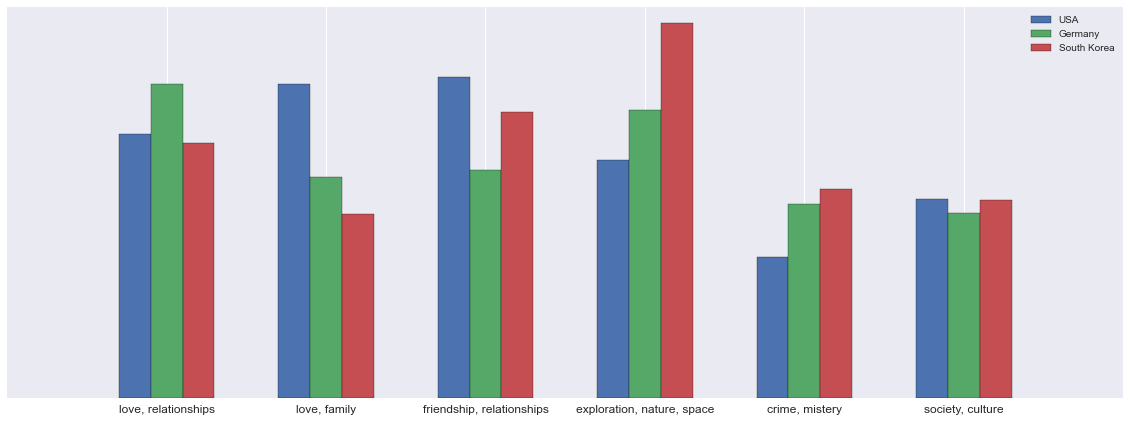

In [589]:
# some help from here: http://stackoverflow.com/questions/14270391/python-matplotlib-multiple-bars
top_topics = toptopics(imdb_topic_df, num=6)
topics, usscores  = get_topic_scores(pop_usa, top_topics)
_, gescores  = get_topic_scores(pop_ge, top_topics)
_, skscores  = get_topic_scores(pop_sk, top_topics)
_, ukscores  = get_topic_scores(pop_uk, top_topics)

plt.figure(figsize=(20,7))
palette = sns.color_palette()
x = range(len(topics))
print x
plt.bar([e-0.2 for e in x], usscores, width=0.2,color = palette[0],align='center',label='USA' )
plt.bar(x, gescores,width=0.2,color = palette[1],align='center' ,label='Germany')
plt.bar([e+0.2 for e in x], skscores,width=0.2,color = palette[2],align='center' ,label='South Korea')
#plt.bar([e+0.4 for e in x], ukscores,width=0.2,color = palette[3],align='center' ,label='United Kingdom')
labels = [imdb_topic_labels[key] for key in topics]
plt.xticks(x, labels,fontsize=12)
plt.yticks([])
plt.legend()
plt.show()

We see that the popularity of different topics is quite similar across the countries. But we can make out some differences especially when comparing the USA with South Korea. For example, while the 'love,family' topic is prevalent in the USA (along with 'friendship, relationship', the 'exploration, nature, space' topic is much more popular in South Korea. 

### Topic popularity over time

Now let's have a look at the development of topics over time. We have collected boxoffice data for USA and Germany since 2001 and for South Korea since 2007.

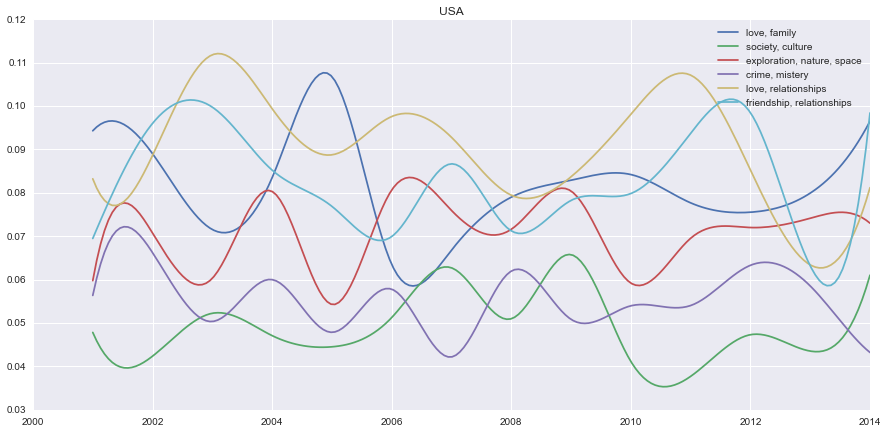

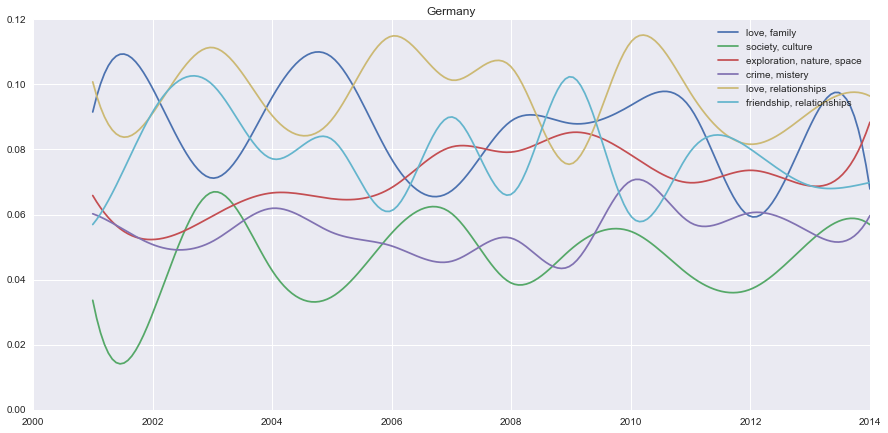

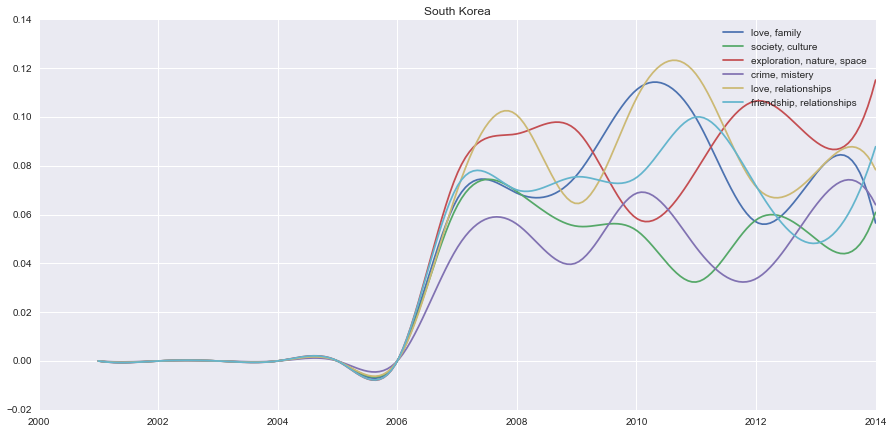

In [628]:
def key2label(d):
    for key in d.keys():
        d[imdb_topic_labels[key]] = d.pop(key)

years = range(2001,2015)
pop_usa_scores_year = get_topic_scores_year(pop_usa, top_topics, years)
key2label(pop_usa_scores_year)
years = range(2001,2015)
pop_sk_scores_year = get_topic_scores_year(pop_sk, top_topics, years)
key2label(pop_sk_scores_year)
pop_ge_scores_year = get_topic_scores_year(pop_ge, top_topics, years)
key2label(pop_ge_scores_year)
def timeseries(score_dict, title):
    plt.figure(figsize=(15,7))
    for topic in score_dict.keys():
        x = years
        y = score_dict[topic]
        x_smooth = np.linspace(min(x), max(x), 200)
        y_smooth = spline(x, y, x_smooth)
        plt.plot(x_smooth, y_smooth, label=topic)
    plt.title(title)
    plt.legend()  
    plt.show
timeseries(pop_usa_scores_year, 'USA')
timeseries(pop_ge_scores_year, 'Germany')
timeseries(pop_sk_scores_year, 'South Korea')


In [ ]:
years = range(2001,2015)
topic_scores_year = get_topic_scores_year(imdb_topic_df, top_topics, years)
key2label(topic_scores_year)
plt.figure(figsize=(20,7))
from scipy.interpolate  import spline
for topic in topic_scores_year.keys():
    x = years
    y = topic_scores_year[topic]
    x_smooth = np.linspace(min(x), max(x), 100)
    y_smooth = spline(x, y, x_smooth)
    plt.plot(x_smooth,y_smooth, label=topic)
plt.legend()    